In [14]:
import os
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
import json
from history import plot_history, save_history

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [17]:
def retrieve_data():
    precipitation_url = 'https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/national/time-series/110-pcp-all-12-1900-2020.json'
    cache_dir = './'
    cache_subdir = "data"
    filename = "monthly_precipitation.json"
    precip_file = tf.keras.utils.get_file(filename, precipitation_url, cache_dir=cache_dir, cache_subdir=cache_subdir)

    with open(precip_file) as f:
        precip_raw = json.load(f)

    precip_data = precip_raw['data']

    time = []
    precipitation = []

    for month in precip_data:
        time.append(month)
        precipitation.append(float(precip_data[month]['value']))

    return np.array(precipitation), time

In [ ]:
monthly_precip, time_dates = retrieve_data()
time_steps = list(range(len(time_dates)))


In [28]:
def split_data(sequence, time, split_time):
    main_seq = sequence[:split_time]
    main_time = time[:split_time]

    extra_seq = sequence[split_time:]
    extra_time = sequence[split_time:]

    print(f'Splitting into {len(main_seq)} main examples and {len(extra_seq)} extra samples. ')

    return main_seq, main_time, extra_seq, extra_time

In [29]:
def wrangle_data(sequence, data_split, examples, batch_size):
    examples = examples + 1
    seq_expand = tf.expand_dims(sequence, -1)
    dataset = tf.data.Dataset.from_tensor_slices(seq_expand)
    dataset = dataset.window(examples, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda b: b.batch(examples))
    dataset = dataset.map(lambda x: (x[:-1],x[-1]))

    if data_split == 'train':
        dataset = dataset.shuffle(10000)
    else:
        dataset = dataset.cache()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset

In [30]:
min_precip = np.min(monthly_precip)
max_precip = np.max(monthly_precip)
precip_norm = (monthly_precip - min_precip)/(max_precip - min_precip)

test_split = time_dates.index('200001')
valid_split = time_dates.index('199001')


train_valid_sp, train_valid_time, test_sp, test_time = split_data(precip_norm, time_steps, test_split)
train_sp, train_time, valid_sp, valid_time = split_data(train_valid_sp, train_valid_time, valid_split)

Splitting into 1200 main examples and 252 extra samples. 
Splitting into 1080 main examples and 120 extra samples. 


In [31]:
examples = 6
batch_size = 16

train_data = wrangle_data(train_sp, 'train', examples, batch_size)
valid_data = wrangle_data(valid_sp, 'valid', examples, batch_size)
test_data = wrangle_data(test_sp, 'test', examples, batch_size)


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [32]:
def compile_model(new_model):
    new_model.compile(optimizer='adam', loss='mae', metrics=[tf.metrics.RootMeanSquaredError()])
    print(new_model.summary())
    return new_model

In [33]:
def rnn_model():
    new_model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer((None, 1)),
        tf.keras.layers.Conv1D(64, 3, padding='causal', activation='relu'),
        tf.keras.layers.LSTM(48),
        tf.keras.layers.Dense(36, activation="relu"),
        tf.keras.layers.Dense(1)
    ])
    return compile_model(new_model)

In [34]:
def plot_sequence(time, sequences, start=0, end=None):
    y_min, y_max = (0.0, 1.0)
    if len(np.shape(sequences)) == 1:
        sequences = [sequences]
    time = time[start:end]
    plt.figure(figsize=(28, 8))
    for sequence in sequences:
        y_max = max(np.max(sequence), y_max)
        y_min = min(np.min(sequence), y_min)
        sequence = sequence[start:end]
        plt.plot(time, sequence)
    plt.ylim(y_min, y_max)
    plt.xlim(np.min(time), np.max(time))

In [35]:
def save_model(model, name, history, test_data):
    test_loss, test_rmse = model.evaluate(test_data)

    # Save model information
    save_name = f'models/precip/{name}-{len(history.epoch):02d}-{test_rmse:0.4f}'
    model.save(f'{save_name}.h5')

    # Save history information
    save_history(history, save_name)

In [36]:
def show_predictions(trained_model, predict_sequence, true_values, predict_time, begin=0, end=None):
    predictions = trained_model.predict(predict_sequence)
    predictions = predictions[:, -1].reshape(len(predictions))
    plot_sequence(predict_time, (true_values, predictions), begin, end)
    return predictions

In [39]:
model_name = 'rnn'
early_stop = EarlyStopping('val_loss', patience=15, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=f'ckpts/precip/{model_name}/' + '{epoch:02d}-{val_loss:.4f}')

model = rnn_model()
history = model.fit(train_data, epochs=100, validation_data=valid_data,
                    callbacks=[early_stop, checkpoint])

save_model(model, model_name, history, test_data)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 64)          256       
                                                                 
 lstm (LSTM)                 (None, 48)                21696     
                                                                 
 dense (Dense)               (None, 36)                1764      
                                                                 
 dense_1 (Dense)             (None, 1)                 37        
                                                                 
Total params: 23,753
Trainable params: 23,753
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
     66/Unknown - 3s 3ms/step - loss: 0.1674 - root_mean_squared_error: 0.2188

INFO:tensorflow:Assets written to: ckpts/precip/rnn\01-0.1075\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\01-0.1075\assets


68/68 [==============================] - 8s 81ms/step - loss: 0.1669 - root_mean_squared_error: 0.2180 - val_loss: 0.1075 - val_root_mean_squared_error: 0.1365
Epoch 2/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1190 - root_mean_squared_error: 0.1484

INFO:tensorflow:Assets written to: ckpts/precip/rnn\02-0.1037\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\02-0.1037\assets


68/68 [==============================] - 5s 68ms/step - loss: 0.1187 - root_mean_squared_error: 0.1486 - val_loss: 0.1037 - val_root_mean_squared_error: 0.1284
Epoch 3/100
66/68 [============================>.] - ETA: 0s - loss: 0.1157 - root_mean_squared_error: 0.1442

INFO:tensorflow:Assets written to: ckpts/precip/rnn\03-0.1078\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\03-0.1078\assets


68/68 [==============================] - 4s 65ms/step - loss: 0.1153 - root_mean_squared_error: 0.1437 - val_loss: 0.1078 - val_root_mean_squared_error: 0.1381
Epoch 4/100
67/68 [============================>.] - ETA: 0s - loss: 0.1133 - root_mean_squared_error: 0.1427

INFO:tensorflow:Assets written to: ckpts/precip/rnn\04-0.0993\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\04-0.0993\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1133 - root_mean_squared_error: 0.1426 - val_loss: 0.0993 - val_root_mean_squared_error: 0.1243
Epoch 5/100
58/68 [========================>.....] - ETA: 0s - loss: 0.1140 - root_mean_squared_error: 0.1420

INFO:tensorflow:Assets written to: ckpts/precip/rnn\05-0.1032\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\05-0.1032\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1134 - root_mean_squared_error: 0.1422 - val_loss: 0.1032 - val_root_mean_squared_error: 0.1254
Epoch 6/100
62/68 [==========================>...] - ETA: 0s - loss: 0.1110 - root_mean_squared_error: 0.1400

INFO:tensorflow:Assets written to: ckpts/precip/rnn\06-0.1242\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\06-0.1242\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1101 - root_mean_squared_error: 0.1390 - val_loss: 0.1242 - val_root_mean_squared_error: 0.1550
Epoch 7/100
62/68 [==========================>...] - ETA: 0s - loss: 0.1114 - root_mean_squared_error: 0.1396

INFO:tensorflow:Assets written to: ckpts/precip/rnn\07-0.0975\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\07-0.0975\assets


68/68 [==============================] - 4s 65ms/step - loss: 0.1116 - root_mean_squared_error: 0.1398 - val_loss: 0.0975 - val_root_mean_squared_error: 0.1211
Epoch 8/100
63/68 [==========================>...] - ETA: 0s - loss: 0.1141 - root_mean_squared_error: 0.1446

INFO:tensorflow:Assets written to: ckpts/precip/rnn\08-0.0967\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\08-0.0967\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1134 - root_mean_squared_error: 0.1435 - val_loss: 0.0967 - val_root_mean_squared_error: 0.1209
Epoch 9/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1102 - root_mean_squared_error: 0.1378

INFO:tensorflow:Assets written to: ckpts/precip/rnn\09-0.0964\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\09-0.0964\assets


68/68 [==============================] - 4s 65ms/step - loss: 0.1102 - root_mean_squared_error: 0.1379 - val_loss: 0.0964 - val_root_mean_squared_error: 0.1219
Epoch 10/100
59/68 [=========================>....] - ETA: 0s - loss: 0.1072 - root_mean_squared_error: 0.1345

INFO:tensorflow:Assets written to: ckpts/precip/rnn\10-0.1208\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\10-0.1208\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1093 - root_mean_squared_error: 0.1364 - val_loss: 0.1208 - val_root_mean_squared_error: 0.1516
Epoch 11/100
65/68 [===========================>..] - ETA: 0s - loss: 0.1090 - root_mean_squared_error: 0.1372

INFO:tensorflow:Assets written to: ckpts/precip/rnn\11-0.1081\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\11-0.1081\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1090 - root_mean_squared_error: 0.1372 - val_loss: 0.1081 - val_root_mean_squared_error: 0.1376
Epoch 12/100
67/68 [============================>.] - ETA: 0s - loss: 0.1106 - root_mean_squared_error: 0.1392

INFO:tensorflow:Assets written to: ckpts/precip/rnn\12-0.0956\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\12-0.0956\assets


68/68 [==============================] - 5s 66ms/step - loss: 0.1104 - root_mean_squared_error: 0.1390 - val_loss: 0.0956 - val_root_mean_squared_error: 0.1208
Epoch 13/100
68/68 [==============================] - ETA: 0s - loss: 0.1092 - root_mean_squared_error: 0.1377

INFO:tensorflow:Assets written to: ckpts/precip/rnn\13-0.1053\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\13-0.1053\assets


68/68 [==============================] - 5s 67ms/step - loss: 0.1092 - root_mean_squared_error: 0.1377 - val_loss: 0.1053 - val_root_mean_squared_error: 0.1343
Epoch 14/100
56/68 [=======================>......] - ETA: 0s - loss: 0.1113 - root_mean_squared_error: 0.1400

INFO:tensorflow:Assets written to: ckpts/precip/rnn\14-0.1040\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\14-0.1040\assets


68/68 [==============================] - 5s 66ms/step - loss: 0.1104 - root_mean_squared_error: 0.1387 - val_loss: 0.1040 - val_root_mean_squared_error: 0.1327
Epoch 15/100
66/68 [============================>.] - ETA: 0s - loss: 0.1094 - root_mean_squared_error: 0.1375

INFO:tensorflow:Assets written to: ckpts/precip/rnn\15-0.0999\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\15-0.0999\assets


68/68 [==============================] - 5s 75ms/step - loss: 0.1089 - root_mean_squared_error: 0.1370 - val_loss: 0.0999 - val_root_mean_squared_error: 0.1274
Epoch 16/100
65/68 [===========================>..] - ETA: 0s - loss: 0.1088 - root_mean_squared_error: 0.1373

INFO:tensorflow:Assets written to: ckpts/precip/rnn\16-0.1161\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\16-0.1161\assets


68/68 [==============================] - 5s 68ms/step - loss: 0.1086 - root_mean_squared_error: 0.1370 - val_loss: 0.1161 - val_root_mean_squared_error: 0.1469
Epoch 17/100
57/68 [========================>.....] - ETA: 0s - loss: 0.1095 - root_mean_squared_error: 0.1389

INFO:tensorflow:Assets written to: ckpts/precip/rnn\17-0.0967\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\17-0.0967\assets


68/68 [==============================] - 4s 63ms/step - loss: 0.1102 - root_mean_squared_error: 0.1392 - val_loss: 0.0967 - val_root_mean_squared_error: 0.1229
Epoch 18/100
56/68 [=======================>......] - ETA: 0s - loss: 0.1063 - root_mean_squared_error: 0.1336

INFO:tensorflow:Assets written to: ckpts/precip/rnn\18-0.0958\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\18-0.0958\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1082 - root_mean_squared_error: 0.1365 - val_loss: 0.0958 - val_root_mean_squared_error: 0.1216
Epoch 19/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1093 - root_mean_squared_error: 0.1371

INFO:tensorflow:Assets written to: ckpts/precip/rnn\19-0.0983\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\19-0.0983\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1096 - root_mean_squared_error: 0.1374 - val_loss: 0.0983 - val_root_mean_squared_error: 0.1250
Epoch 20/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1079 - root_mean_squared_error: 0.1357

INFO:tensorflow:Assets written to: ckpts/precip/rnn\20-0.0966\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\20-0.0966\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1079 - root_mean_squared_error: 0.1359 - val_loss: 0.0966 - val_root_mean_squared_error: 0.1203
Epoch 21/100
60/68 [=========================>....] - ETA: 0s - loss: 0.1096 - root_mean_squared_error: 0.1386

INFO:tensorflow:Assets written to: ckpts/precip/rnn\21-0.1010\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\21-0.1010\assets


68/68 [==============================] - 4s 62ms/step - loss: 0.1096 - root_mean_squared_error: 0.1384 - val_loss: 0.1010 - val_root_mean_squared_error: 0.1287
Epoch 22/100
63/68 [==========================>...] - ETA: 0s - loss: 0.1097 - root_mean_squared_error: 0.1387

INFO:tensorflow:Assets written to: ckpts/precip/rnn\22-0.0955\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\22-0.0955\assets


68/68 [==============================] - 4s 60ms/step - loss: 0.1091 - root_mean_squared_error: 0.1377 - val_loss: 0.0955 - val_root_mean_squared_error: 0.1211
Epoch 23/100
63/68 [==========================>...] - ETA: 0s - loss: 0.1094 - root_mean_squared_error: 0.1382

INFO:tensorflow:Assets written to: ckpts/precip/rnn\23-0.1084\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\23-0.1084\assets


68/68 [==============================] - 4s 62ms/step - loss: 0.1090 - root_mean_squared_error: 0.1376 - val_loss: 0.1084 - val_root_mean_squared_error: 0.1383
Epoch 24/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1115 - root_mean_squared_error: 0.1401

INFO:tensorflow:Assets written to: ckpts/precip/rnn\24-0.0957\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\24-0.0957\assets


68/68 [==============================] - 4s 62ms/step - loss: 0.1124 - root_mean_squared_error: 0.1410 - val_loss: 0.0957 - val_root_mean_squared_error: 0.1214
Epoch 25/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1082 - root_mean_squared_error: 0.1361

INFO:tensorflow:Assets written to: ckpts/precip/rnn\25-0.0953\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\25-0.0953\assets


68/68 [==============================] - 4s 60ms/step - loss: 0.1085 - root_mean_squared_error: 0.1362 - val_loss: 0.0953 - val_root_mean_squared_error: 0.1208
Epoch 26/100
65/68 [===========================>..] - ETA: 0s - loss: 0.1092 - root_mean_squared_error: 0.1372

INFO:tensorflow:Assets written to: ckpts/precip/rnn\26-0.0962\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\26-0.0962\assets


68/68 [==============================] - 4s 63ms/step - loss: 0.1088 - root_mean_squared_error: 0.1368 - val_loss: 0.0962 - val_root_mean_squared_error: 0.1219
Epoch 27/100
61/68 [=========================>....] - ETA: 0s - loss: 0.1087 - root_mean_squared_error: 0.1366

INFO:tensorflow:Assets written to: ckpts/precip/rnn\27-0.0972\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\27-0.0972\assets


68/68 [==============================] - 4s 59ms/step - loss: 0.1087 - root_mean_squared_error: 0.1371 - val_loss: 0.0972 - val_root_mean_squared_error: 0.1233
Epoch 28/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1089 - root_mean_squared_error: 0.1364

INFO:tensorflow:Assets written to: ckpts/precip/rnn\28-0.0981\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\28-0.0981\assets


68/68 [==============================] - 4s 62ms/step - loss: 0.1086 - root_mean_squared_error: 0.1364 - val_loss: 0.0981 - val_root_mean_squared_error: 0.1214
Epoch 29/100
62/68 [==========================>...] - ETA: 0s - loss: 0.1086 - root_mean_squared_error: 0.1364

INFO:tensorflow:Assets written to: ckpts/precip/rnn\29-0.1005\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\29-0.1005\assets


68/68 [==============================] - 4s 60ms/step - loss: 0.1093 - root_mean_squared_error: 0.1369 - val_loss: 0.1005 - val_root_mean_squared_error: 0.1281
Epoch 30/100
64/68 [===========================>..] - ETA: 0s - loss: 0.1069 - root_mean_squared_error: 0.1344

INFO:tensorflow:Assets written to: ckpts/precip/rnn\30-0.1052\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\30-0.1052\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1080 - root_mean_squared_error: 0.1354 - val_loss: 0.1052 - val_root_mean_squared_error: 0.1343
Epoch 31/100
63/68 [==========================>...] - ETA: 0s - loss: 0.1084 - root_mean_squared_error: 0.1368

INFO:tensorflow:Assets written to: ckpts/precip/rnn\31-0.0963\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\31-0.0963\assets


68/68 [==============================] - 4s 63ms/step - loss: 0.1088 - root_mean_squared_error: 0.1372 - val_loss: 0.0963 - val_root_mean_squared_error: 0.1223
Epoch 32/100
59/68 [=========================>....] - ETA: 0s - loss: 0.1091 - root_mean_squared_error: 0.1370

INFO:tensorflow:Assets written to: ckpts/precip/rnn\32-0.0974\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\32-0.0974\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1079 - root_mean_squared_error: 0.1360 - val_loss: 0.0974 - val_root_mean_squared_error: 0.1235
Epoch 33/100
58/68 [========================>.....] - ETA: 0s - loss: 0.1086 - root_mean_squared_error: 0.1371

INFO:tensorflow:Assets written to: ckpts/precip/rnn\33-0.0957\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\33-0.0957\assets


68/68 [==============================] - 5s 66ms/step - loss: 0.1094 - root_mean_squared_error: 0.1377 - val_loss: 0.0957 - val_root_mean_squared_error: 0.1201
Epoch 34/100
61/68 [=========================>....] - ETA: 0s - loss: 0.1054 - root_mean_squared_error: 0.1331

INFO:tensorflow:Assets written to: ckpts/precip/rnn\34-0.1081\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\34-0.1081\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1081 - root_mean_squared_error: 0.1366 - val_loss: 0.1081 - val_root_mean_squared_error: 0.1382
Epoch 35/100
54/68 [======================>.......] - ETA: 0s - loss: 0.1072 - root_mean_squared_error: 0.1353

INFO:tensorflow:Assets written to: ckpts/precip/rnn\35-0.0991\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\35-0.0991\assets


68/68 [==============================] - 4s 64ms/step - loss: 0.1077 - root_mean_squared_error: 0.1359 - val_loss: 0.0991 - val_root_mean_squared_error: 0.1261
Epoch 36/100
62/68 [==========================>...] - ETA: 0s - loss: 0.1103 - root_mean_squared_error: 0.1394

INFO:tensorflow:Assets written to: ckpts/precip/rnn\36-0.0958\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\36-0.0958\assets


68/68 [==============================] - 4s 61ms/step - loss: 0.1108 - root_mean_squared_error: 0.1395 - val_loss: 0.0958 - val_root_mean_squared_error: 0.1217
Epoch 37/100
66/68 [============================>.] - ETA: 0s - loss: 0.1086 - root_mean_squared_error: 0.1363

INFO:tensorflow:Assets written to: ckpts/precip/rnn\37-0.1029\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\37-0.1029\assets


68/68 [==============================] - 5s 67ms/step - loss: 0.1078 - root_mean_squared_error: 0.1357 - val_loss: 0.1029 - val_root_mean_squared_error: 0.1315
Epoch 38/100
56/68 [=======================>......] - ETA: 0s - loss: 0.1068 - root_mean_squared_error: 0.1348

INFO:tensorflow:Assets written to: ckpts/precip/rnn\38-0.1182\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\38-0.1182\assets


68/68 [==============================] - 4s 66ms/step - loss: 0.1087 - root_mean_squared_error: 0.1372 - val_loss: 0.1182 - val_root_mean_squared_error: 0.1492
Epoch 39/100
62/68 [==========================>...] - ETA: 0s - loss: 0.1084 - root_mean_squared_error: 0.1370

INFO:tensorflow:Assets written to: ckpts/precip/rnn\39-0.0956\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\39-0.0956\assets


68/68 [==============================] - 4s 63ms/step - loss: 0.1082 - root_mean_squared_error: 0.1367 - val_loss: 0.0956 - val_root_mean_squared_error: 0.1211
Epoch 40/100
66/68 [============================>.] - ETA: 0s - loss: 0.1089 - root_mean_squared_error: 0.1371

INFO:tensorflow:Assets written to: ckpts/precip/rnn\40-0.0955\assets


INFO:tensorflow:Assets written to: ckpts/precip/rnn\40-0.0955\assets


16/16 [==============================] - 0s 3ms/step - loss: 0.0995 - root_mean_squared_error: 0.1293


16/16 [==============================] - 1s 3ms/step


array([0.60666823, 0.51690227, 0.45995632, 0.47893953, 0.4934256 ,
       0.53790516, 0.47158843, 0.46336687, 0.4951688 , 0.53136533,
       0.50011694, 0.54451156, 0.5839442 , 0.5446973 , 0.5054284 ,
       0.5032486 , 0.47217953, 0.49625677, 0.50924474, 0.4817658 ,
       0.428559  , 0.51138467, 0.51629895, 0.5376328 , 0.54021096,
       0.5337544 , 0.5099706 , 0.53164726, 0.5622568 , 0.47834918,
       0.53924704, 0.44620478, 0.503047  , 0.53523785, 0.5409002 ,
       0.59306467, 0.6128663 , 0.5293997 , 0.5019024 , 0.52729005,
       0.45602107, 0.49988806, 0.51488596, 0.47783574, 0.51205295,
       0.48871267, 0.51500684, 0.597565  , 0.621311  , 0.5650171 ,
       0.5457261 , 0.5385664 , 0.5404782 , 0.5577819 , 0.48365903,
       0.5063641 , 0.4781385 , 0.49053183, 0.52590936, 0.5473714 ,
       0.5786945 , 0.54203486, 0.5464207 , 0.47075826, 0.48408088,
       0.49312335, 0.4989351 , 0.5317913 , 0.45450705, 0.49143392,
       0.53184944, 0.51295584, 0.5294782 , 0.52491486, 0.54353

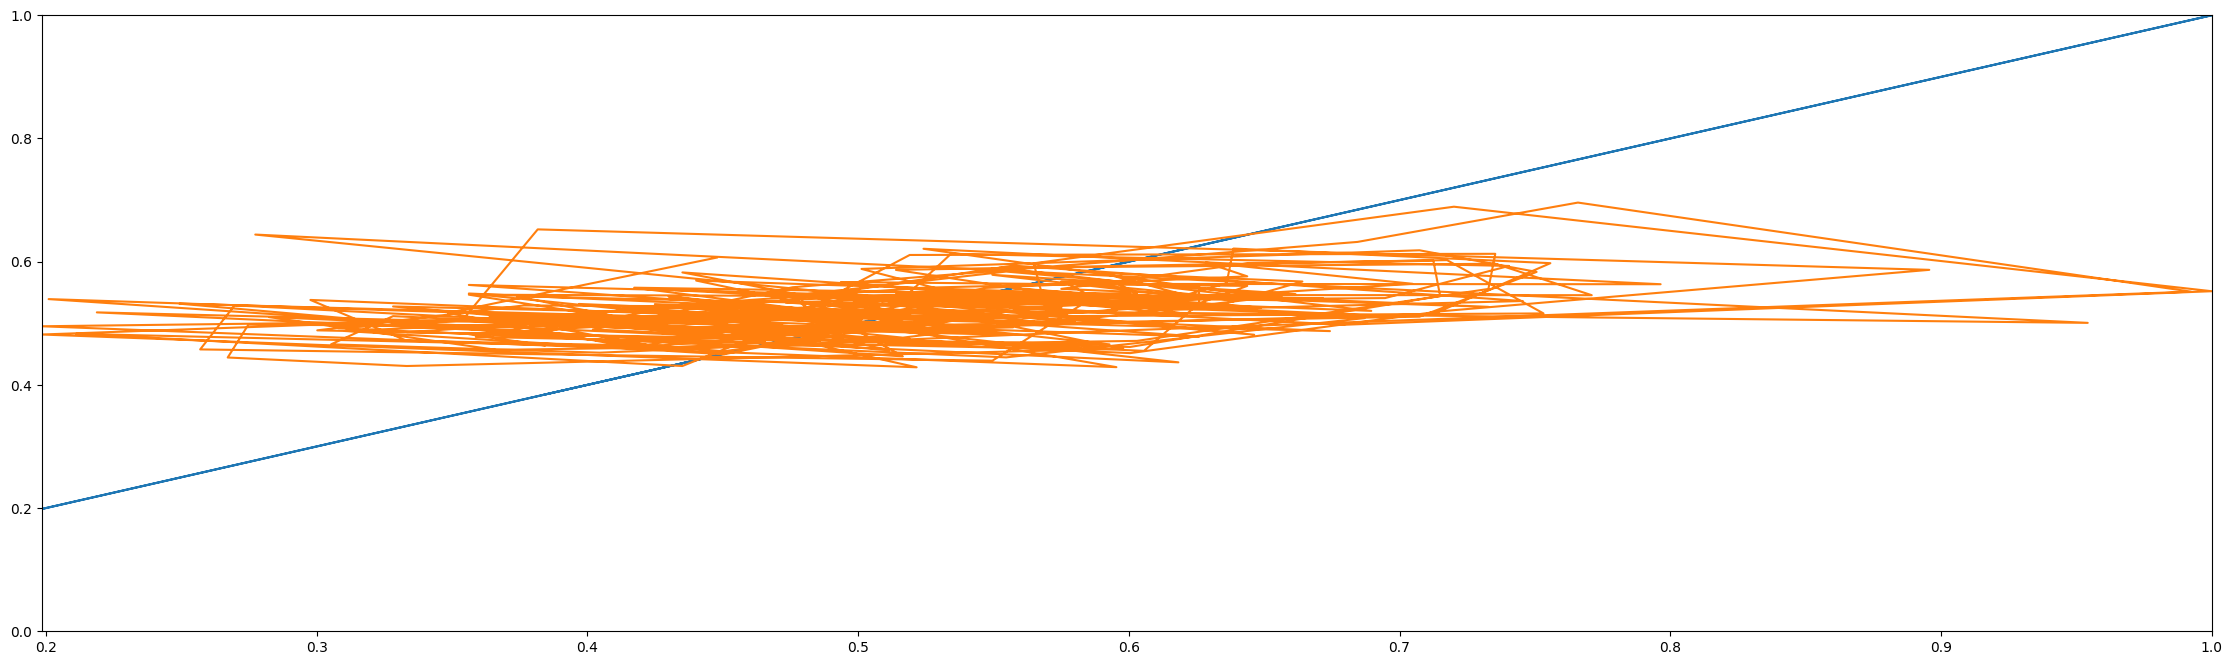

In [40]:
show_predictions(model, test_data, test_sp[examples:], test_time[examples:])

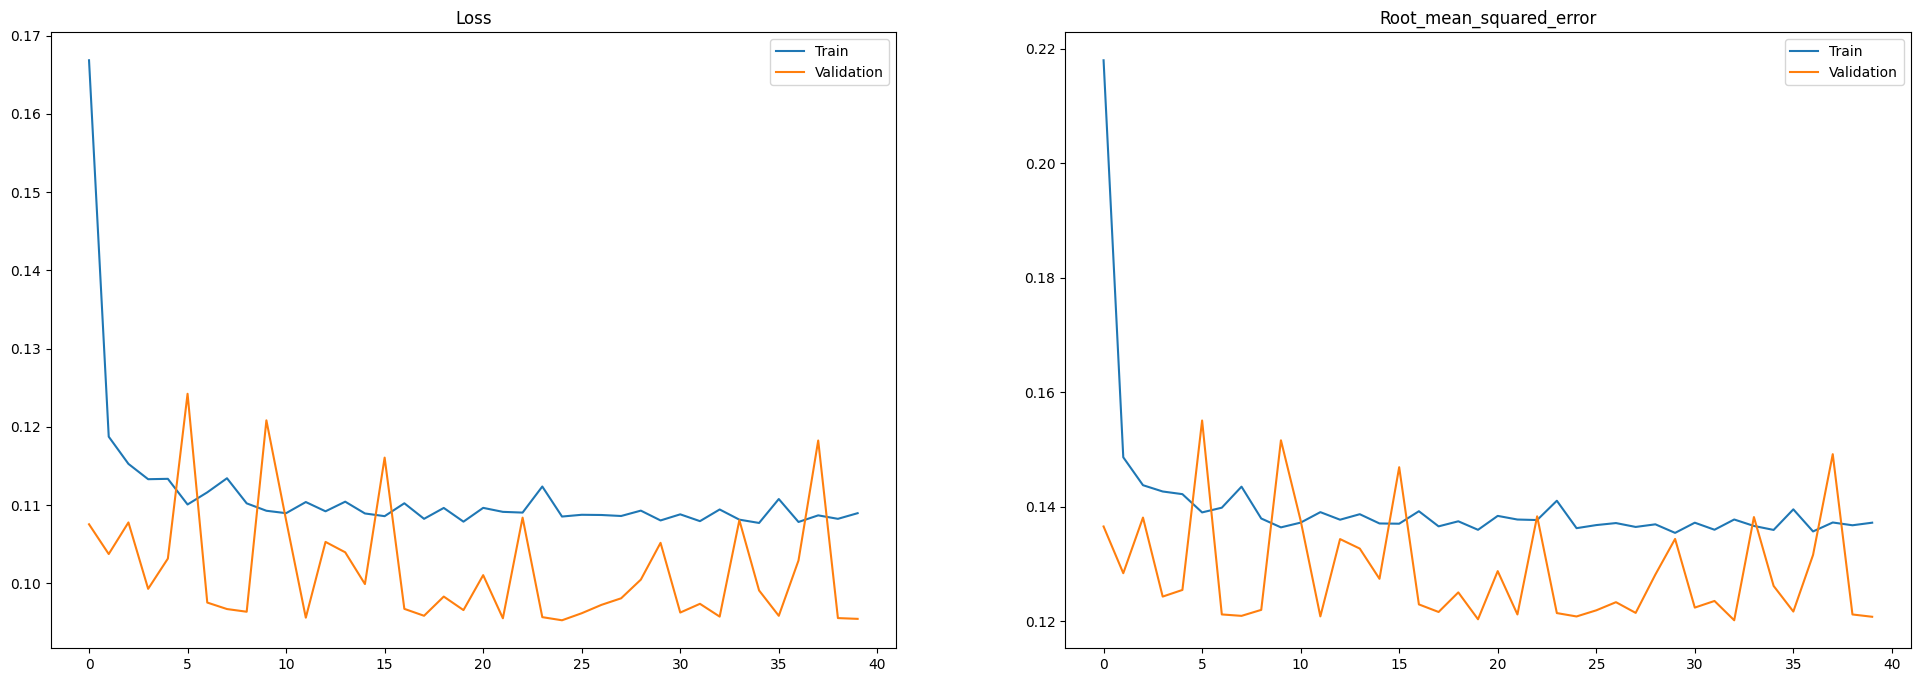

In [41]:
plot_history(history)